## <center> Binary Classification of COVID-19 Radiography </center>

---

### Dependencies

In [88]:
%pip install notebook --upgrade

Note: you may need to restart the kernel to use updated packages.


In [89]:
%pip install tensorflow opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


### Imports

In [90]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import os

### Loading the Data

In [91]:
# passing the data into the variable 'data' using keras utilities
data = tf.keras.utils.image_dataset_from_directory('/Users/namanbiyani/Desktop/COVID19ImageClassification/data/COVID19ImageDataset')

# making the variable 'data_iterator' a conversion of 'data' to numpy iterator
data_iterator = data.as_numpy_iterator()

Found 222 files belonging to 2 classes.


In [92]:
#grabs first batch from 'data_iterator'
batch = data_iterator.next()

In [93]:
# Class 0 = COVID
# Class 1 = Normal
batch[1]

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1], dtype=int32)

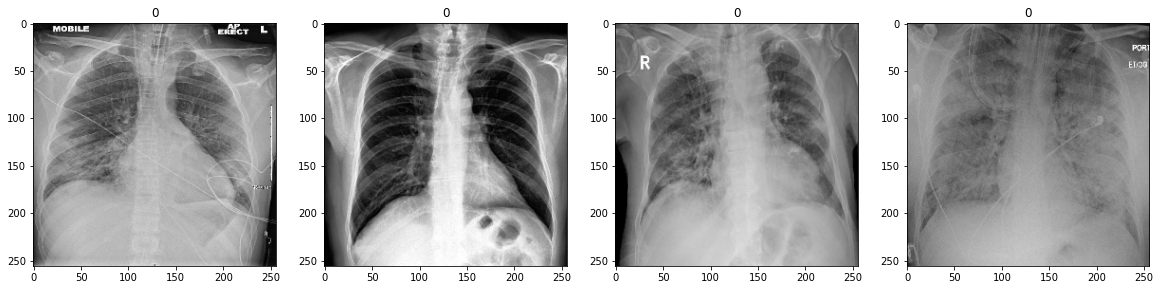

In [94]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

### Preprocessing the Data

#### Scaling the data for optimization

In [95]:
# The map function applies this lambda through the data pipeline
# The lambda divides 'x' by 255 to leave the data with only [1.0, 0.0]
# This optimizes the CNN
data = data.map(lambda x, y: (x/255, y))

In [96]:
scaled_iterator = data.as_numpy_iterator()

In [97]:
scaled_iterator.next()[0].min()

0.0

#### Allocating batches to either Training or Validation

In [98]:
len(data)

7

In [99]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2) + 1
test_size = int(len(data)*.1) + 1

In [100]:
train_size

4

In [101]:
# Checking if we have used all our batches
train_size + val_size + test_size

7

In [102]:
train = data.take(train_size)
validation = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

### Building the Deep Model using the Kera sequential API

#### The Model

In [103]:
# Sequential API is a keras model to use when you have 1 input and 1 output
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [104]:
model = Sequential()

#### Adding the layers to the Sequential Model

##### A Relu function that trims all of the negative values to zero and maintains the positives

<img src = "/Users/namanbiyani/Desktop/COVID19ImageClassification/src/images/relu-demo.webp" width = "495" height = "323">

##### A Sigmoid function that converst any output into a range between zero and one

![](/Users/namanbiyani/Desktop/COVID19ImageClassification/src/images/sigmoid-demo.png)

In [105]:
# The Documentation of Conv2D
Conv2D??

Init signature: Conv2D(*args, **kwargs)
Source:        
@keras_export('keras.layers.Conv2D', 'keras.layers.Convolution2D')
class Conv2D(Conv):
  """2D convolution layer (e.g. spatial convolution over images).

  This layer creates a convolution kernel that is convolved
  with the layer input to produce a tensor of
  outputs. If `use_bias` is True,
  a bias vector is created and added to the outputs. Finally, if
  `activation` is not `None`, it is applied to the outputs as well.

  When using this layer as the first layer in a model,
  provide the keyword argument `input_shape`
  (tuple of integers or `None`, does not include the sample axis),
  e.g. `input_shape=(128, 128, 3)` for 128x128 RGB pictures
  in `data_format="channels_last"`. You can use `None` when
  a dimension has variable size.

  Examples:

  >>> # The inputs are 28x28 RGB images with `channels_last` and the batch
  >>> # size is 4.
  >>> input_shape = (4, 28, 28, 3)
  >>> x = tf.random.normal(input_shape)
  >>> y = tf.

In [106]:
# Conv2D scans over the data and condenses and extracts the relevant information
# MaxPooling2D returns the maximum value out of a 2 by 2 region after the relu function has been applied
# MaxPooling2D condenses the output further
model.add(Conv2D(16, (3, 3), 1, activation = 'relu', input_shape = (256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation = 'relu'))
model.add(MaxPooling2D())

# Converts the output to a single channel
model.add(Flatten())

# The sigmoid activation reshapes the output to a range between zero and one
# Class 0 = COVID
# Class 1 = Normal
model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [107]:
# Compiling the Sequential model using the 'adam' optimizer
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [108]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

#### Training

In [109]:
log_dir = '/Users/namanbiyani/Desktop/COVID19ImageClassification/log'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

In [110]:
model.fit??

Signature:
model.fit(
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose='auto',
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)
Source:   
  @traceback_utils.filter_traceback
  def fit(self,
          x=None,
          y=None,
          batch_size=None,
          epochs=1,
          verbose='auto',
          callbacks=None,
          validation_split=0.,
          validation_data=None,
          shuffle=True,
          class_weight=None,
          sample_weight=None,
          initial_epoch=0,
          steps_per_epoch=None,
          validation_steps=None,
          validation_batch_size=None,
          validation_freq=1,
          max_queue_size=10,
          workers=1,
         

In [111]:
hist = model.fit(train, epochs = 20, validation_data = validation, callbacks = [tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 11s 2s/step - loss: 0.9212 - accuracy: 0.5312 - val_loss: 0.6880 - val_accuracy: 0.3750
Epoch 2/20
4/4 [==============================] - 9s 2s/step - loss: 0.6378 - accuracy: 0.4766 - val_loss: 0.5389 - val_accuracy: 0.9688
Epoch 3/20
4/4 [==============================] - 8s 2s/step - loss: 0.4497 - accuracy: 0.8750 - val_loss: 0.2435 - val_accuracy: 0.9375
Epoch 4/20
4/4 [==============================] - 8s 2s/step - loss: 0.3794 - accuracy: 0.7812 - val_loss: 0.1348 - val_accuracy: 0.9844
Epoch 5/20
4/4 [==============================] - 8s 2s/step - loss: 0.1468 - accuracy: 0.9453 - val_loss: 0.0692 - val_accuracy: 1.0000
Epoch 6/20
4/4 [==============================] - 8s 2s/step - loss: 0.0831 - accuracy: 0.9844 - val_loss: 0.0696 - val_accuracy: 0.9688
Epoch 7/20
4/4 [==============================] - 8s 2s/step - loss: 0.0536 - accuracy: 0.9844 - val_loss: 0.0585 - val_accuracy: 0.9688
Epoch 8/20
4/4 [========================

##### Creating a plot showing the relation between the loss and validation loss

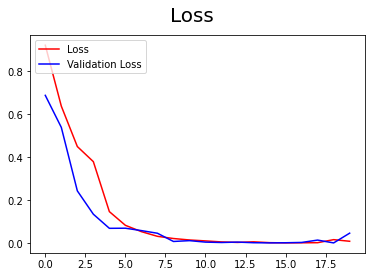

In [112]:
figure = plt.figure()
plt.plot(hist.history['loss'], color = 'red', label = 'Loss')
plt.plot(hist.history['val_loss'], color = 'blue', label = 'Validation Loss')
figure.suptitle('Loss', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

##### Creating a plot showing the relation between accuracu and validation accuracy

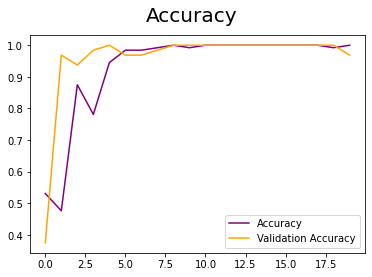

In [113]:
figure = plt.figure()
plt.plot(hist.history['accuracy'], color = 'purple', label = 'Accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'Validation Accuracy')
figure.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = "lower right")
plt.show()

### Evaulating Performance

In [114]:
# Precision, Recall, and BinaryAccuracy are common metrics used to evaluate CNN models
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [115]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [120]:
# For each batch in testing data, unpack the data, then update the metrics
for batch in test.as_numpy_iterator():
  x, y = batch
  yhat = model.predict(x)
  precision.update_state(y, yhat)
  recall.update_state(y, yhat)
  accuracy.update_state(y, yhat)

1/1 [==============================] - 0s 222ms/step


In [123]:
print("Precision: ", precision.result().numpy())
print("Recall: ", recall.result().numpy())
print("Accuracy: ", accuracy.result().numpy())

Precision:  1.0
Recall:  0.96428573
Accuracy:  0.98333335


### Testing the Model

##### This section takes in images that the model has never seen before and inputs them into the CNN

In [125]:
import cv2

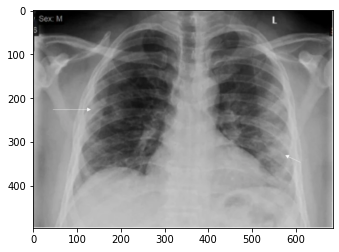

In [223]:
img = cv2.imread('/Users/namanbiyani/Desktop/COVID19ImageClassification/tests/COVID_test1.jpeg')
plt.imshow(img)
plt.show()

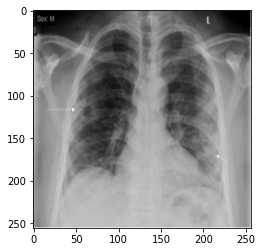

In [224]:
# Resizing the image as the CNN only takes images that are 256x256
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [225]:
# The CNN only takes input in batches, so I convert the image 'resize' into a batch
np.expand_dims(resize, 0)
# Passes into model
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 27ms/step


In [226]:
print("%.16f" % (float(yhat)))

0.0000602419131610


#### The closer the result of yhat is to zero, the more likely that the radiography contains COVID-19

In [227]:
if yhat < 0.50:
  print("Prediction that the radiography passed in contains a patient with COVID-19")
  print("Prediction Confidence: " + str(1.0 - float(yhat)) + "%")
else:
  print("Prediction that the radiography passed in contains a patient without COVID-19")
  print("Prediction Confidence: " + str(float(yhat)) + "%")

Prediction that the radiography passed in contains a patient with COVID-19
Prediction Confidence: 0.999939758086839%
